In [59]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import os
import cv2
from PIL import Image
import pandas as pd
from skimage import io, color, feature, exposure,transform
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix ,log_loss ,roc_curve, auc ,silhouette_score
import tensorflow as tf
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sns

In [60]:
# Function to extract HOG features from an image and visualize it
def extract_hog_features(image):
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)  # used for object detection.

    # Calculate HOG features
    hog_features, hog_image = feature.hog(gray_image, visualize=True)

    # Enhance the contrast of the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) #make it more visually interpretable.

    return hog_features, hog_image_rescaled  #The function returns the computed HOG features and the enhanced HOG image.

In [79]:
# Path to the root folder of your dataset
dataset_path = 'C:\\Users\\dell\\Downloads\\archive (1)'

# List all subdirectories (assuming each subdirectory corresponds to a class)
class_folders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
features_list=[]
labels_list=[]
# Loop through each class folder
for class_folder in class_folders:
    class_name = os.path.basename(class_folder)

    # Loop through each image in the class folder
    for image_filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_filename)

        # Load the image
        image = io.imread(image_path)
        
        target_size = (32, 64)  

        # Resize image to a consistent size
        resized_image = np.array(Image.fromarray(image).resize(target_size))

        # Extract HOG features and visualize
        hog_features, hog_image = extract_hog_features(resized_image)

        # Append HOG features to the features list
        features_list.append(hog_features)

        # Append the label to the labels list
        labels_list.append(class_name)

In [62]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
# Use LabelEncoder to convert class names into numeric labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)
print(features_array)
print(numeric_labels)

[[0.03417261 0.34142342 0.30837763 ... 0.         0.         0.        ]
 [0.04814896 0.32505693 0.18864984 ... 0.         0.         0.        ]
 [0.05696783 0.2958427  0.29846012 ... 0.         0.         0.00754672]
 ...
 [0.03188141 0.25627011 0.12714161 ... 0.         0.         0.        ]
 [0.03016105 0.26184098 0.15351215 ... 0.         0.         0.        ]
 [0.02630165 0.26876762 0.06861194 ... 0.         0.         0.00598012]]
[0 0 0 ... 3 3 3]


In [80]:
print(features_array.shape)

(4217, 972)


In [63]:
# Now, perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(features_array, numeric_labels, test_size=0.2, random_state=42)

In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3373, 972)
(844, 972)
(3373,)
(844,)


In [65]:
# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

In [66]:

# Train Logistic Regression only if there are at least two classes
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_shuffled,y_train_shuffled)

LogisticRegression(max_iter=1000)

In [67]:
# Predict on test set
predictions = logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of logistic regression with HOG features: {accuracy}")

Accuracy of logistic regression with HOG features: 0.7713270142180095


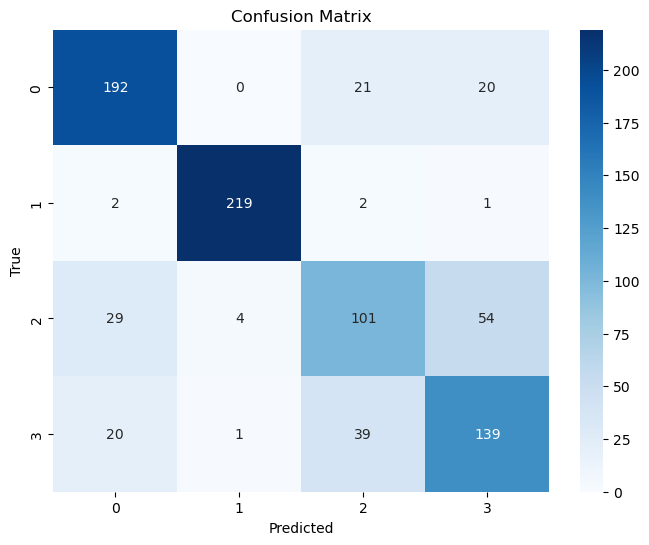

In [68]:
y_pred = logreg.predict(X_test)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

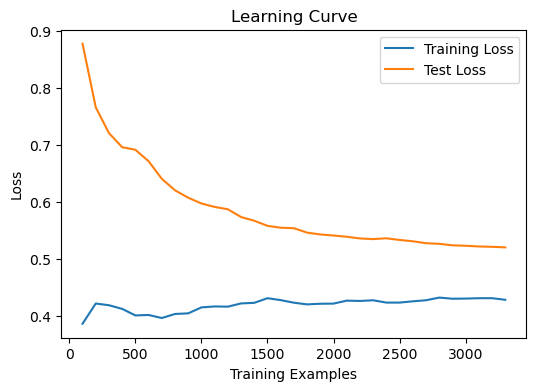

In [69]:
train_losses = []
test_losses = []

# Training the model and calculating loss for each iteration
for i in range(100, len(X_train_shuffled), 100):  
    logreg.fit(X_train_shuffled[:i], y_train_shuffled[:i])
    train_pred = logreg.predict_proba(X_train_shuffled[:i])
    test_pred = logreg.predict_proba(X_test)
    
    train_loss = log_loss(y_train_shuffled[:i], train_pred)
    test_loss = log_loss(y_test, test_pred)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plotting the learning curve
plt.figure(figsize=(6, 4))
plt.plot(range(100, len(X_train_shuffled), 100), train_losses, label='Training Loss')
plt.plot(range(100, len(X_train_shuffled), 100), test_losses, label='Test Loss')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Loss')
plt.legend()
plt.show()

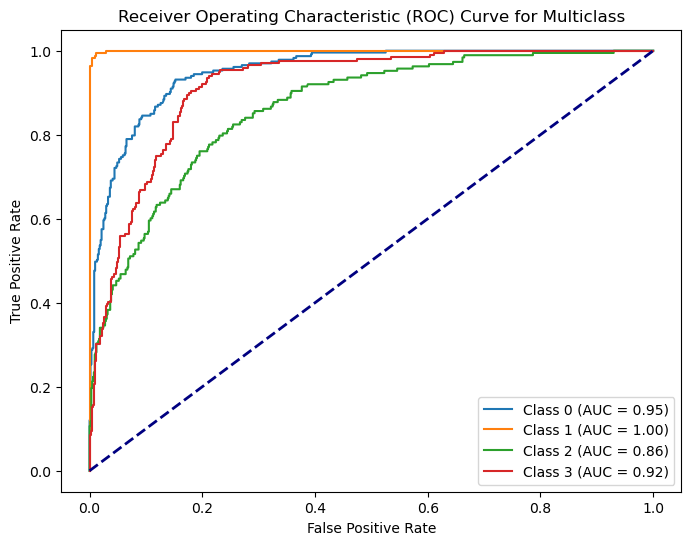

In [70]:
model = OneVsRestClassifier(logreg) # to work with multiclassification
model.fit(X_train_shuffled, y_train_shuffled)
# Get predicted probabilities for the positive class
y_pred_probs = model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_test == model.classes_[i]).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend()
plt.show()

# K-Means Model

In [71]:
# PCA to reduce dimensionality
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_train_shuffled)

# Apply KMeans clustering
num_clusters = 4 
kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init=10)
kmeans.fit(X_pca)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_
# Get cluster labels
cluster_labels = kmeans.predict(X_pca)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.574825364600947


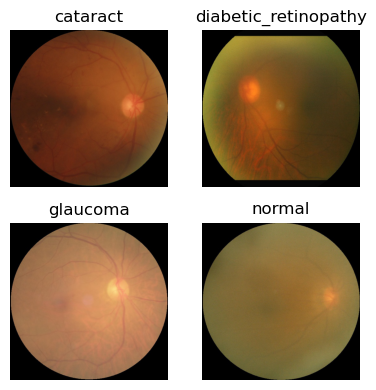

In [72]:
from pathlib import Path
# List all image files in the dataset
image_files = list(Path(dataset_path).rglob('*.jpg')) + list(Path(dataset_path).rglob('*.png')) + list(Path(dataset_path).rglob('*.jpeg'))

class_mapping_df = pd.DataFrame({'cluster': [0, 1, 2, 3], 'class_name': ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']})

# Visualize the clustered images
fig, axes = plt.subplots(2, 2, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    cluster_number = i  # Adjust cluster numbering starting from 0
    cluster_indices = np.where(np.array(y_test) == cluster_number)[0]
    
    if len(cluster_indices) > 0:
        for j, idx in enumerate(cluster_indices[:4]):  # Display the first 4 images from each cluster
            if idx < len(image_files):  # Check if the index is within the range of image_files
                image = io.imread(image_files[idx])
                ax.imshow(image)

                # Check if there are matching rows for the current cluster_number
                matching_rows = class_mapping_df[class_mapping_df['cluster'] == cluster_number]
                
                if not matching_rows.empty:
                    class_name = matching_rows['class_name'].values[0]
                    ax.set_title(f'{class_name}')
                else:
                    ax.set_title(f'Cluster {cluster_number}')
                    
                ax.axis('off')
    else:
        ax.axis('off')  # If there are no images in the cluster, turn off the axis

# Remove overlapping axes
for ax in fig.get_axes():
    ax.label_outer()

plt.tight_layout()
plt.show()

